## Setup

In [1]:
import deeptrack as DT
import imageGeneration as IG
import benchmark
import unet
import cv2
import numpy as np

In [2]:
#bugfix for fredrik REMOVE LATER
import tensorflow as tf
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], False)

## Generate images using our method

In [3]:
import os
import glob

def get_image_parameters_preconfig(image_size=256):
    from numpy.random import uniform, randint
    from numpy import ones
    from math import pi
    
    #particle_number = randint(2,5)
    particle_number = 0
    particle_radius_list = uniform(1,3, particle_number)
    (particle_center_x_list, particle_center_y_list) = IG.generate_particle_positions(particle_radius_list, image_size)

    particle_bessel_orders_list = []
    particle_intensities_list = []

    for i in range(particle_number):
        particle_bessel_orders_list.append([1, ])
        particle_intensities_list.append([uniform(0.3, 0.5, 1), ])

    image_parameters = IG.get_image_parameters(
        particle_center_x_list=lambda: particle_center_x_list,
        particle_center_y_list=lambda: particle_center_y_list,
        particle_radius_list=lambda: particle_radius_list,
        particle_bessel_orders_list=lambda: particle_bessel_orders_list,
        particle_intensities_list=lambda: particle_intensities_list,
        image_size=lambda: image_size,
        image_background_level=lambda: uniform(.2, .5),
        signal_to_noise_ratio=lambda: uniform(5,100),
        gradient_intensity=lambda: uniform(0, 0.1),
        gradient_direction=lambda: uniform(-pi, pi),
        ellipsoidal_orientation=lambda: uniform(-pi, pi, particle_number),
        ellipticity=lambda: 1)

    return image_parameters


get_image_parameters_function=lambda: get_image_parameters_preconfig(image_size = 51)

number_of_images_to_save = 25
batch_images,batch_labels,batch_predictions, particle_positions_and_radiuses = IG.get_batch(get_image_parameters_function = get_image_parameters_function,
                                                                                            batch_size=number_of_images_to_save,
                                                                                            include_particle_positions_radii_and_intensities = True) 



files = glob.glob('./images/*')
for f in files:
    os.remove(f)
        
for image_number,image in enumerate(batch_images):
    if image_number>=number_of_images_to_save:
        break
    
    filepath = './images/frame{}.jpg'.format(str(image_number))
    image = image*255
    cv2.imwrite(filepath,image)

cv2.destroyAllWindows()

Time taken for batch generation of size 25: 0.04694080352783203 s.


### Construct video from images


In [4]:
benchmark.construct_video_from_images(number_of_images_to_save)

## Optimization

In [5]:
def get_op_chars(predicted_positions,
                 particle_positions_and_radiuses,
                 image_size_x, image_size_y,
                 scanning_box_size_x, scanning_box_size_y,
                 scanning_box_step_x, scanning_box_step_y):
    
    operating_characteristics_sum = [0,0,0,0,0,0]
    for i in range(len(particle_positions_and_radiuses)):
        
        current_particle_positions_x = particle_positions_and_radiuses[i][0]
        current_particle_positions_y = particle_positions_and_radiuses[i][1]
        
        current_predicted_particle_positions_x = []
        current_predicted_particle_positions_y = []
        for pred in predicted_positions:
            if(pred[0] == i):
                current_predicted_particle_positions_x.append(pred[1])
                current_predicted_particle_positions_y.append(pred[2])
                
    
        current_operating_characteristics_optimized = benchmark.get_operating_characteristics_scanning_box_optimized(current_predicted_particle_positions_x,
                                                                                                 current_predicted_particle_positions_y,
                                                                                                 current_particle_positions_x, 
                                                                                                 current_particle_positions_y,
                                                                                                 image_size_x, image_size_y,
                                                                                                 scanning_box_size_x, 
                                                                                                 scanning_box_size_y,
                                                                                                 scanning_box_step_x,
                                                                                                 scanning_box_step_y)
        operating_characteristics_sum = [sum(x) for x in zip(operating_characteristics_sum, current_operating_characteristics_optimized)]
    

    operating_characteristics = [x / len(particle_positions_and_radiuses) for x in operating_characteristics_sum]
        
    return tuple(operating_characteristics)

In [6]:
def get_optimal_parameters(predicted_positions_wrt_frame,
                           particle_positions_and_radiuses,
                           image_size_x, image_size_y,
                           sample_size=100,
                           number_of_iterations = 2,
                           x0=[20,10],
                           verbose = False):
    
    
    import numpy as np
    from scipy.optimize import minimize
    from scipy.special import expit

    
    def func(x, label, pred, sample_size,image_size_x, image_size_y):
        predicted_positions_DT = benchmark.get_predicted_positions_DT(x[0],
                                                                      x[1],
                                                                      sample_size,
                                                                      pred,
                                                                      verbose = False)
        
        scanning_box_size_x = image_size_x / 12
        scanning_box_size_y = image_size_y / 12
        scanning_box_step_x = scanning_box_size_x / 4
        scanning_box_step_y = scanning_box_size_y / 4
        
        operating_characteristics = get_op_chars(predicted_positions_DT,
                                                 label,
                                                 image_size_x, image_size_y,
                                                 scanning_box_size_x, scanning_box_size_y,
                                                 scanning_box_step_x, scanning_box_step_y)
        
        
        
        dist = benchmark.distance_from_upper_left_corner_ROC(operating_characteristics, FPR_weight=100.0)
        
        return dist

    sample_size = min([sample_size, predicted_positions_wrt_frame.shape[0]])

   
    label = particle_positions_and_radiuses
    pred = predicted_positions_wrt_frame
    current_guess = minimize(func, x0, args=(label, pred, sample_size,image_size_x, image_size_y), tol=1e-6, method='Nelder-Mead').x
    if(verbose):
            func_value = func(current_guess, label, pred, sample_size,image_size_x, image_size_y)
            print("On iteration: {}, Current_guess: {} , func_value: {}".format(0,current_guess, func_value))
            
    for k in range(number_of_iterations):
        temp = minimize(func, current_guess, args=(label, pred, sample_size, image_size_x, image_size_y), tol=1e-6, method='Nelder-Mead').x
        current_guess = temp
        if(verbose):
            func_value = func(current_guess, label, pred, sample_size,image_size_x, image_size_y)
            print("On iteration: {}, Current_guess: {} , func_value: {}".format(k+1,current_guess, func_value))
        

    return current_guess

In [7]:
def get_optimal_parameters_unet(batch_predictions,
                           particle_positions_and_radiuses,
                           image_size_x, image_size_y,
                           sample_size=100,
                           number_of_iterations = 2,
                           x0=0.8,
                           verbose = False):
    
    
    import numpy as np
    from scipy.optimize import minimize
    from scipy.special import expit

    
    def func(x, label, pred, sample_size,image_size_x, image_size_y):
        
        predicted_positions_unet = benchmark.get_predicted_positions_unet(sample_size,
                                                                      pred,
                                                                      image_size_x,
                                                                      image_size_y,
                                                                      cutoff_value = x)
        
        scanning_box_size_x = image_size_x / 24
        scanning_box_size_y = image_size_y / 24
        scanning_box_step_x = scanning_box_size_x / 4
        scanning_box_step_y = scanning_box_size_y / 4
        
        operating_characteristics = get_op_chars(predicted_positions_unet,
                                                 label,
                                                 image_size_x, image_size_y,
                                                 scanning_box_size_x, scanning_box_size_y,
                                                 scanning_box_step_x, scanning_box_step_y)
        
        
        
        dist = benchmark.distance_from_upper_left_corner_ROC(operating_characteristics, FPR_weight=100.0)
        
        return dist

    sample_size = min([sample_size, batch_predictions.shape[0]])
   
    label = particle_positions_and_radiuses
    pred = batch_predictions
    bnds = [(0,1)]
    
    current_guess = minimize(func, x0,
                             args=(label, pred, sample_size,image_size_x, image_size_y),
                             tol=1e-6,
                             bounds = bnds).x
    
    
    if(verbose):
            func_value = func(current_guess, label, pred, sample_size,image_size_x, image_size_y)
            print("On iteration: {}, Current_guess: {} , func_value: {}".format(0,current_guess, func_value))
            
    for k in range(number_of_iterations):
        temp = minimize(func, 
                        current_guess,
                        args=(label, pred, sample_size, image_size_x, image_size_y),
                        tol=1e-9,
                        bounds = bnds).x
        
        current_guess = temp
        if(verbose):
            func_value = func(current_guess, label, pred, sample_size,image_size_x, image_size_y)
            print("On iteration: {}, Current_guess: {} , func_value: {}".format(k+1,current_guess, func_value))
        

    return current_guess

In [111]:
saved_network_file_name = "DeepTrack - Example 3 - Pretrained network.h5"
dt_model = DT.load(saved_network_file_name)

video = cv2.VideoCapture("output.mp4")
(number_frames_to_be_tracked, frames, predicted_positions_wrt_frame, predicted_positions_wrt_box, 
 boxes_all) = DT.track_video("output.mp4", dt_model,box_half_size = 10,box_scanning_step = 2,frame_normalize = 0,frame_enhance = 1,number_frames_to_be_tracked = 0)


In [49]:
import time

image_size_x = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
image_size_y = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

scanning_box_size_x = image_size_x / 12
scanning_box_size_y = image_size_y / 12
scanning_box_step_x = scanning_box_size_x / 100
scanning_box_step_y = scanning_box_size_y / 100

t = time.time()
params = get_optimal_parameters(predicted_positions_wrt_frame,
                                particle_positions_and_radiuses,
                                image_size_x, image_size_y,
                                sample_size=100,
                                x0=[12,5],
                                verbose = True,
                                number_of_iterations = 2)

t2 = time.time()-t
print(params)
print("time taken: {} sec".format(t2))

On iteration: 0, Current_guess: [5.03481475 6.98132659] , func_value: 0.5122094557806106
On iteration: 1, Current_guess: [5.02165043 6.98132659] , func_value: 0.5122094557806106
On iteration: 2, Current_guess: [5.02165043 6.98132659] , func_value: 0.5122094557806106
[5.02165043 6.98132659]
time taken: 31.830482721328735 sec


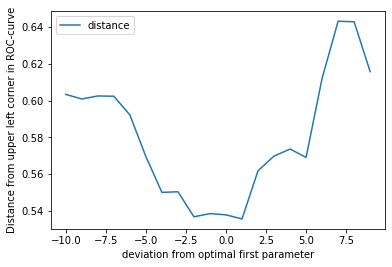

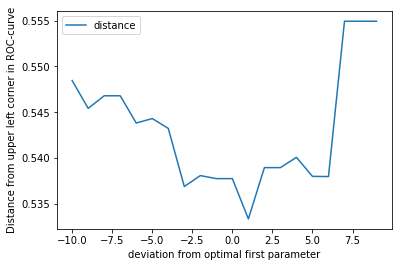

In [47]:
import matplotlib.pyplot as plt

params = params
diffs = range(-10,10,1)
distance = np.zeros(len(diffs))

verbose = False

for i,diff in enumerate(diffs,0):
    predicted_positions_DT = benchmark.get_predicted_positions_DT(params[0]+diff/10,
                                                                  params[1],
                                                                  number_frames_to_be_tracked,
                                                                  predicted_positions_wrt_frame,
                                                                  verbose = False)


    image_size_x = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    image_size_y = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    scanning_box_size_x = image_size_x / 12
    scanning_box_size_y = image_size_y / 12
    scanning_box_step_x = scanning_box_size_x / 100
    scanning_box_step_y = scanning_box_size_y / 100


    P, N, TP, FP, TN, FN = get_op_chars(predicted_positions_DT,
                                        particle_positions_and_radiuses,
                                        image_size_x, image_size_y,
                                        scanning_box_size_x, scanning_box_size_y,
                                        scanning_box_step_x, scanning_box_step_y)

    
    dist = benchmark.distance_from_upper_left_corner_ROC((P, N, TP, FP, TN, FN),100)
    distance[i] = dist
    
    if(verbose):print(dist)


plt.plot(diffs,distance,label = "distance")
plt.legend(loc="upper left")
plt.xlabel("deviation from optimal first parameter")
plt.ylabel("Distance from upper left corner in ROC-curve")
plt.show()




##now vary second parameter
diffs = range(-10,10,1)
distance = np.zeros(len(diffs))

verbose = False

for i,diff in enumerate(diffs,0):
    predicted_positions_DT = benchmark.get_predicted_positions_DT(params[0],
                                                                  params[1]+diff/10,
                                                                  number_frames_to_be_tracked,
                                                                  predicted_positions_wrt_frame,
                                                                  verbose = False)


    image_size_x = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    image_size_y = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    scanning_box_size_x = image_size_x / 12
    scanning_box_size_y = image_size_y / 12
    scanning_box_step_x = scanning_box_size_x / 100
    scanning_box_step_y = scanning_box_size_y / 100


    P, N, TP, FP, TN, FN = get_op_chars(predicted_positions_DT,
                                        particle_positions_and_radiuses,
                                        image_size_x, image_size_y,
                                        scanning_box_size_x, scanning_box_size_y,
                                        scanning_box_step_x, scanning_box_step_y)

    
    dist = benchmark.distance_from_upper_left_corner_ROC((P, N, TP, FP, TN, FN),100)
    distance[i] = dist
    
    if(verbose):print(dist)

plt.plot(diffs,distance,label = "distance")
plt.legend(loc="upper left")
plt.xlabel("deviation from optimal first parameter")
plt.ylabel("Distance from upper left corner in ROC-curve")
plt.show()

## Testing opt function for unet


In [8]:
import time

video = cv2.VideoCapture("output.mp4")
video_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
video_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))

batch_images = np.zeros((number_of_images_to_save,video_height,video_width,1))


for i in range(number_of_images_to_save):
    (ret, frame) = video.read()
    batch_images[i,:,:,0] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)/255

model = unet.create_unet(pretrained_weights = "unet_particle.hdf5")
batch_predictions_unet = unet.predict(model,batch_images)


image_size_x = video_width
image_size_y = video_height

scanning_box_size_x = image_size_x / 12
scanning_box_size_y = image_size_y / 12
scanning_box_step_x = scanning_box_size_x / 100
scanning_box_step_y = scanning_box_size_y / 100

t = time.time()
params = get_optimal_parameters_unet(batch_predictions_unet,
                                particle_positions_and_radiuses,
                                image_size_x, image_size_y,
                                sample_size=100,
                                x0=0.8,
                                verbose = True,
                                number_of_iterations = 2)

t2 = time.time()-t
print(params)
print("time taken: {} sec".format(t2))

Using TensorFlow backend.


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node conv2d_1/convolution (defined at C:\Users\fredr\Miniconda3\envs\kand\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]] [Op:__inference_keras_scratch_graph_1406]

Function call stack:
keras_scratch_graph


## MAE and MSE as function of SNR

In [9]:
def image_parameters_function(lower_limit_SNR, higher_limit_SNR, image_size = 256):
    from numpy.random import uniform, randint
    from numpy import ones
    from math import pi
    
    #particle_number = randint(1, 3)
    particle_number = 1
    particle_radius_list = uniform(1, 3, particle_number)
    (particle_center_x_list, particle_center_y_list) = IG.generate_particle_positions(particle_radius_list, image_size)

    particle_bessel_orders_list = []
    particle_intensities_list = []

    for i in range(particle_number):
        particle_bessel_orders_list.append([1, ])
        particle_intensities_list.append([uniform(0.05, 0.13, 1), ])

    image_parameters = IG.get_image_parameters(
        particle_center_x_list=lambda: particle_center_x_list,
        particle_center_y_list=lambda: particle_center_y_list,
        particle_radius_list=lambda: particle_radius_list,
        particle_bessel_orders_list=lambda: particle_bessel_orders_list,
        particle_intensities_list=lambda: particle_intensities_list,
        image_size=lambda: image_size,
        image_background_level=lambda: uniform(.3, .5),
        signal_to_noise_ratio=lambda: uniform(lower_limit_SNR, higher_limit_SNR),
        gradient_intensity=lambda: uniform(0, 0),
        gradient_direction=lambda: uniform(-pi, pi),
        ellipsoidal_orientation=lambda: uniform(-pi, pi, particle_number),
        ellipticity=lambda: 1)

    return image_parameters

Iteration: 0, SNR: 5
Time taken for iteration 0 : 21.232951164245605 sec


Iteration: 1, SNR: 10
Time taken for iteration 1 : 18.656657218933105 sec


Iteration: 2, SNR: 15
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
Time taken for iteration 2 : 24.546616792678833 sec


Iteration: 3, SNR: 20
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
par

particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no

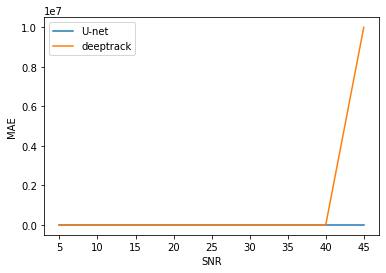

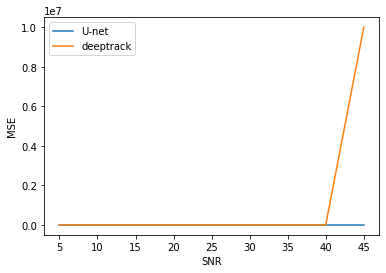

In [28]:
from numpy import zeros
import matplotlib.pyplot as plt
import os
import glob
import time

number_of_images_to_save = 50
model = unet.create_unet(pretrained_weights = "unet_particle.hdf5")

#particle_radial_distance_threshold = 10
#particle_maximum_interdistance = 5

particle_radial_distance_threshold = params[0]
particle_maximum_interdistance = params[1]

SNRs = range(5,50,5)
unet_MAE = zeros(len(SNRs))
unet_MSE = zeros(len(SNRs))
DT_MAE = zeros(len(SNRs))
DT_MSE = zeros(len(SNRs))

files = glob.glob('./images/*')
for f in files:
    os.remove(f)


verbose = True

for itt,lower_SNR in enumerate(SNRs,0):
    if(verbose):
        print("Iteration: {}, SNR: {}".format(itt, lower_SNR))
        t = time.time()
    
    get_image_parameters_function=lambda: image_parameters_function(lower_SNR,lower_SNR + 5,image_size = 51)

    batch_images,batch_labels,batch_predictions, particle_positions_and_radiuses = IG.get_batch(get_image_parameters_function = get_image_parameters_function,
                                                                                                batch_size=number_of_images_to_save,
                                                                                                include_particle_positions_radii_and_intensities = True,
                                                                                                verbose = False) 
    
    
    
    
        
    for image_number,image in enumerate(batch_images):
        if image_number>=number_of_images_to_save:
            break
        else:
            filepath = './images/frame{}.jpg'.format(str(image_number))
            image = image*255
            cv2.imwrite(filepath,image)

    cv2.destroyAllWindows()
    
    benchmark.construct_video_from_images()
    
    saved_network_file_name = "DeepTrack - Example 3 - Pretrained network.h5"
    dt_model = DT.load(saved_network_file_name)

    video = cv2.VideoCapture("output.mp4")
    (number_frames_to_be_tracked, frames, predicted_positions_wrt_frame, predicted_positions_wrt_box, 
        boxes_all) = DT.track_video("output.mp4",
                                    dt_model,box_half_size = 10,box_scanning_step = 2,
                                    frame_normalize = 0,frame_enhance = 1,
                                    number_frames_to_be_tracked = 0)
    
    

    predicted_positions_DT = benchmark.get_predicted_positions_DT(particle_radial_distance_threshold,
        particle_maximum_interdistance,
        number_frames_to_be_tracked,
        predicted_positions_wrt_frame)


    nr_real_particles,nr_predictions,nr_TP,nr_FP,TP,FP_DT,links_DT,MAE,MSE = benchmark.hits_and_misses(number_frames_to_be_tracked,
                                                                      predicted_positions_DT,
                                                                      particle_positions_and_radiuses,
                                                                      long_return = True)

    DT_MAE[itt] = MAE
    DT_MSE[itt] = MSE
    
    video_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))

    batch_images = np.zeros((number_frames_to_be_tracked,video_height,video_width,1))


    for i in range(number_frames_to_be_tracked):
        (ret, frame) = video.read()
        batch_images[i,:,:,0] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)/255

    
    batch_predictions_unet = unet.predict(model,batch_images)

    predicted_positions_unet = benchmark.get_predicted_positions_unet(number_frames_to_be_tracked,
                                                                      batch_predictions_unet,
                                                                      video_width,
                                                                      video_height)


    nr_real_particles,nr_predictions,nr_TP,nr_FP,TP,FP_unet,links_unet,MAE,MSE = benchmark.hits_and_misses(number_frames_to_be_tracked,
                                                                      predicted_positions_unet,
                                                                      particle_positions_and_radiuses,
                                                                      long_return = True)

    unet_MAE[itt] = MAE
    unet_MSE[itt] = MSE
    
    if(verbose):
        time_taken = time.time() - t
        print("Time taken for iteration {} : {} sec".format(itt,time_taken))
        print()
        print()

plt.plot(SNRs,unet_MAE,label = "U-net")
plt.plot(SNRs,DT_MAE, label = "deeptrack")
plt.legend(loc="upper left")
plt.xlabel("SNR")
plt.ylabel("MAE")
plt.show()

plt.plot(SNRs,unet_MSE,label = "U-net")
plt.plot(SNRs,DT_MSE, label = "deeptrack")
plt.legend(loc="upper left")
plt.xlabel("SNR")
plt.ylabel("MSE")
plt.show()

In [27]:
print("avg DT MAE: {}".format(np.mean(DT_MAE)))
print("avg DT MSE: {}".format(np.mean(DT_MSE)))
print("avg unet MAE: {}".format(np.mean(unet_MAE)))
print("avg unet MAE: {}".format(np.mean(DT_MSE)))

avg DT MAE: 1111112.3320353774
avg DT MSE: 1111113.462376783
avg unet MAE: 0.5929884276264802
avg unet MAE: 1111113.462376783


In [23]:
print("avg DT MAE: {}".format(np.mean(DT_MAE)))
print("avg DT MSE: {}".format(np.mean(DT_MSE)))
print("avg unet MAE: {}".format(np.mean(unet_MAE)))
print("avg unet MAE: {}".format(np.mean(DT_MSE)))

avg DT MAE: 7777777.2961843945
avg DT MSE: 7777777.4279290335
avg unet MAE: 0.469723214501544
avg unet MAE: 7777777.4279290335
